In [1]:
pip install numpy pandas matplotlib scikit-learn tensorflow imbalanced-learn joblib

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install xgboost

  Using cached xgboost-3.0.2-py3-none-win_amd64.whl.metadata (2.1 kB)
Using cached xgboost-3.0.2-py3-none-win_amd64.whl (150.0 MB)
Note: you may need to restart the kernel to use updated packages.


Data loaded. Shape: (14988, 14)


C:\Users\cam71\AppData\Local\Temp\ipykernel_7484\1964179983.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["SEASON"] = season_encoder.fit_transform(df["SEASON"])


Best RandomForest params: {'max_depth': 16, 'min_samples_split': 5, 'n_estimators': 350}
Best GradientBoosting params: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}
Best LogisticRegression params: {'C': 0.1, 'solver': 'saga'}

--- RandomForest Evaluation ---
Confusion Matrix:
 [[1619  383]
 [ 306  688]]

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.81      0.82      2002
           1       0.64      0.69      0.67       994

    accuracy                           0.77      2996
   macro avg       0.74      0.75      0.75      2996
weighted avg       0.78      0.77      0.77      2996

ROC AUC Score: 0.8257165369841426
Test Set Accuracy: 0.7700267022696929

--- GradientBoosting Evaluation ---
Confusion Matrix:
 [[1674  328]
 [ 362  632]]

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.84      0.83      2002
           1       0.66      0.64      

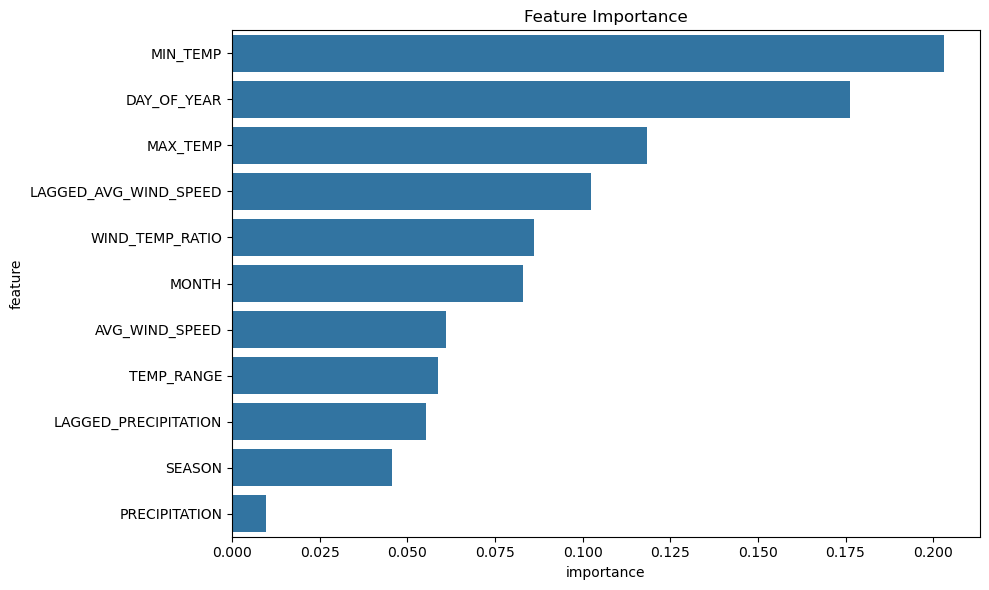

C:\Users\cam71\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\cam71\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\cam71\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training FeedforwardNN
Epoch 1/20
375/375 - 6s - 15ms/step - accuracy: 0.7614 - auc: 0.8088 - loss: 0.4974 - val_accuracy: 0.7637 - val_auc: 0.8192 - val_loss: 0.4812
Epoch 2/20
375/375 - 2s - 5ms/step - accuracy: 0.7743 - auc: 0.8246 - loss: 0.4782 - val_accuracy: 0.7640 - val_auc: 0.8210 - val_loss: 0.4792
Epoch 3/20
375/375 - 3s - 7ms/step - accuracy: 0.7747 - auc: 0.8264 - loss: 0.4759 - val_accuracy: 0.7650 - val_auc: 0.8218 - val_loss: 0.4779
Epoch 4/20
375/375 - 3s - 7ms/step - accuracy: 0.7754 - auc: 0.8293 - loss: 0.4725 - val_accuracy: 0.7657 - val_auc: 0.8224 - val_loss: 0.4773
Epoch 5/20
375/375 - 3s - 7ms/step - accuracy: 0.7768 - auc: 0.8314 - loss: 0.4694 - val_accuracy: 0.7677 - val_auc: 0.8238 - val_loss: 0.4759
Epoch 6/20
375/375 - 2s - 5ms/step - accuracy: 0.7768 - auc: 0.8317 - loss: 0.4690 - val_accuracy: 0.7660 - val_auc: 0.8244 - val_loss: 0.4747
Epoch 7/20
375/375 - 2s - 5ms/step - accuracy: 0.7775 - auc: 0.8331 - loss: 0.4677 - val_accuracy: 0.7657 - val_auc: 0

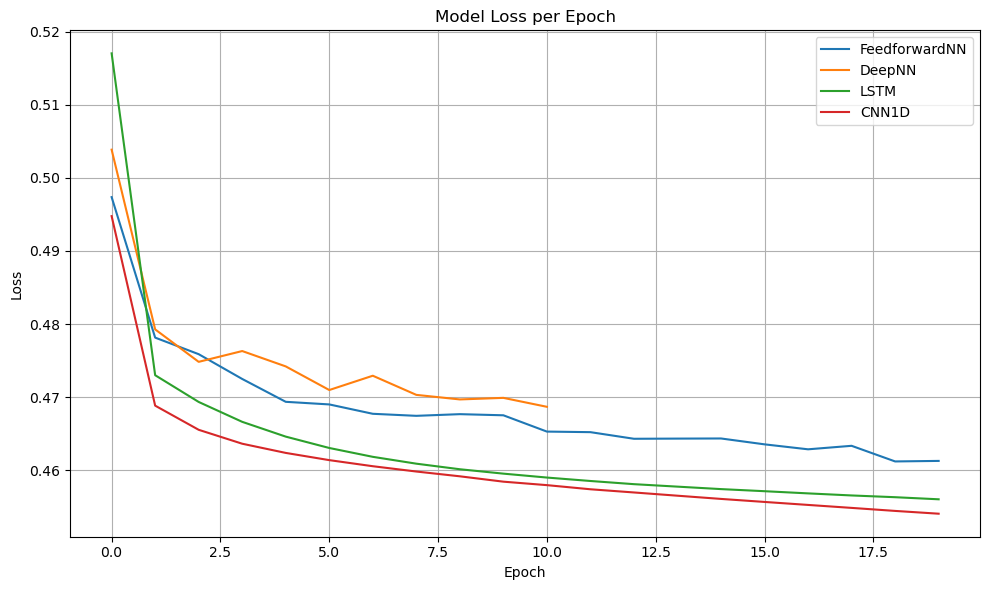

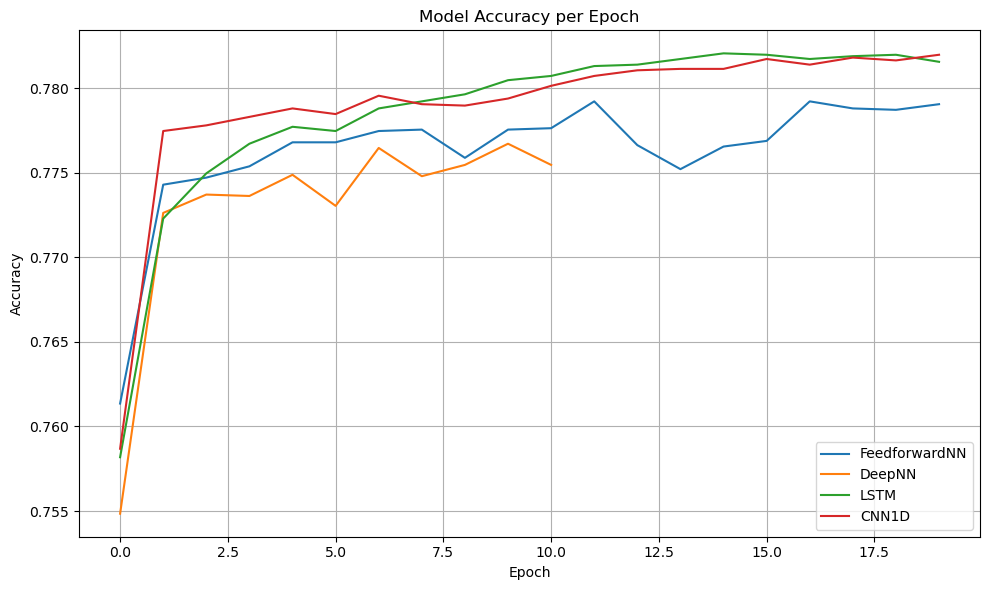

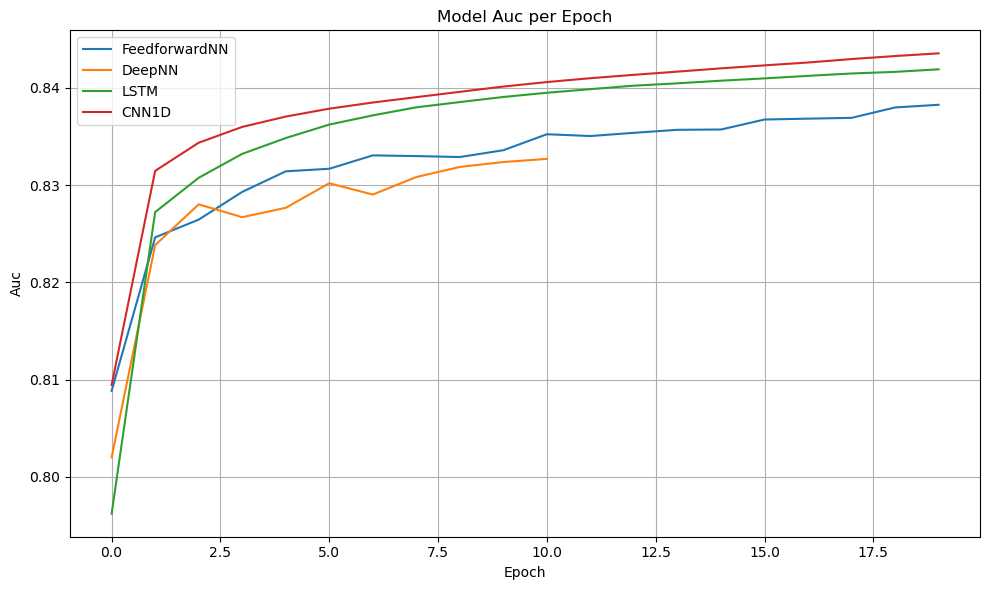

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Conv1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping

# For reproducibility
np.random.seed(42)
tf.random.set_seed(42)

def load_data(filepath):
    df = pd.read_csv(filepath, parse_dates=["DATE"])
    print(f"Data loaded. Shape: {df.shape}")
    return df

def preprocess_data(df):
    df = df.dropna()
    season_encoder = LabelEncoder()
    df["SEASON"] = season_encoder.fit_transform(df["SEASON"])
    return df, season_encoder

def get_features_and_labels(df):
    features = [
        "PRECIPITATION", "MAX_TEMP", "MIN_TEMP", "AVG_WIND_SPEED",
        "TEMP_RANGE", "WIND_TEMP_RATIO", "MONTH", "SEASON",
        "LAGGED_PRECIPITATION", "LAGGED_AVG_WIND_SPEED", "DAY_OF_YEAR"
    ]
    X = df[features]
    y = df["FIRE_START_DAY"].astype(int)
    return X, y, features

def split_data(X, y, test_size=0.2, random_state=42):
    return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

def hyperparameter_tuning(X_train, y_train):
    param_grids = {
        "RandomForest": {
            'n_estimators': [100, 250, 350],
            'max_depth': [None, 16, 32],
            'min_samples_split': [2, 5],
        },
        "GradientBoosting": {
            'n_estimators': [100, 200],
            'learning_rate': [0.05, 0.1, 0.15],
            'max_depth': [3, 5]
        },
        "LogisticRegression": {
            'C': [0.1, 1.0, 10.0],
            'solver': ['liblinear', 'saga']
        }
    }
    best_models = {}
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    rf = RandomForestClassifier(random_state=42, class_weight='balanced')
    gs_rf = GridSearchCV(rf, param_grids["RandomForest"], cv=cv, scoring='roc_auc', n_jobs=-1)
    gs_rf.fit(X_train, y_train)
    print("Best RandomForest params:", gs_rf.best_params_)
    best_models["RandomForest"] = gs_rf.best_estimator_

    gb = GradientBoostingClassifier(random_state=42)
    gs_gb = GridSearchCV(gb, param_grids["GradientBoosting"], cv=cv, scoring='roc_auc', n_jobs=-1)
    gs_gb.fit(X_train, y_train)
    print("Best GradientBoosting params:", gs_gb.best_params_)
    best_models["GradientBoosting"] = gs_gb.best_estimator_

    lr = LogisticRegression(max_iter=2000, random_state=42, class_weight='balanced')
    gs_lr = GridSearchCV(lr, param_grids["LogisticRegression"], cv=cv, scoring='roc_auc', n_jobs=-1)
    gs_lr.fit(X_train, y_train)
    print("Best LogisticRegression params:", gs_lr.best_params_)
    best_models["LogisticRegression"] = gs_lr.best_estimator_
    return best_models

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_test, y_proba))
    print("Test Set Accuracy:", accuracy_score(y_test, y_pred))

def evaluate_all_models(models, X_test, y_test):
    for name, model in models.items():
        print(f"\n--- {name} Evaluation ---")
        evaluate_model(model, X_test, y_test)

def plot_feature_importance(model, features):
    importances = model.feature_importances_
    feature_df = pd.DataFrame({"feature": features, "importance": importances}).sort_values("importance", ascending=False)
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_df, x="importance", y="feature")
    plt.title("Feature Importance")
    plt.tight_layout()
    plt.show()

def save_model(model, filename="wildfire_model.joblib"):
    joblib.dump(model, filename)
    print(f"Model saved to {filename}")

def load_model(filename="wildfire_model.joblib"):
    return joblib.load(filename)

def build_deep_learning_models(input_dim):
    models = {}

    model_ff = Sequential([
        Dense(64, activation='relu', input_dim=input_dim),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model_ff.compile(optimizer='adam', loss='binary_crossentropy',
                     metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    models['FeedforwardNN'] = model_ff

    model_deep = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dropout(0.4),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model_deep.compile(optimizer='adam', loss='binary_crossentropy',
                       metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    models['DeepNN'] = model_deep

    model_lstm = Sequential([
        LSTM(32, input_shape=(1, input_dim), return_sequences=False),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model_lstm.compile(optimizer='adam', loss='binary_crossentropy',
                       metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    models['LSTM'] = model_lstm

    model_cnn = Sequential([
        Conv1D(32, 1, activation='relu', input_shape=(1, input_dim)),
        Flatten(),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model_cnn.compile(optimizer='adam', loss='binary_crossentropy',
                      metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    models['CNN1D'] = model_cnn

    return models

if __name__ == "__main__":
    df = load_data("wildfire_dataset.csv")
    df, season_encoder = preprocess_data(df)
    X, y, features = get_features_and_labels(df)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = split_data(X_scaled, y)

    best_models = hyperparameter_tuning(X_train, y_train)

    try:
        model = load_model()
    except FileNotFoundError:
        model = best_models["RandomForest"]
        model.fit(X_train, y_train)
        save_model(model)

    evaluate_all_models(best_models, X_test, y_test)
    plot_feature_importance(best_models["RandomForest"], features)

    # --- Deep Learning comparison (optional) ---
    deep_models = build_deep_learning_models(X_train.shape[1])
    X_train_seq = X_train.reshape(-1, 1, X_train.shape[1])
    X_test_seq = X_test.reshape(-1, 1, X_test.shape[1])

    history_dict = {}
    for name, dl_model in deep_models.items():
        print(f"Training {name}")
        if name in ['LSTM', 'CNN1D']:
            history = dl_model.fit(
                X_train_seq, y_train,
                validation_data=(X_test_seq, y_test),
                epochs=20, batch_size=32,
                callbacks=[EarlyStopping(patience=3)],
                verbose=2
            )
            results = dl_model.evaluate(X_test_seq, y_test)
        else:
            history = dl_model.fit(
                X_train, y_train,
                validation_data=(X_test, y_test),
                epochs=20, batch_size=32,
                callbacks=[EarlyStopping(patience=3)],
                verbose=2
            )
            results = dl_model.evaluate(X_test, y_test)
        history_dict[name] = history
        print(f"{name} - Test Loss: {results[0]}, Test Accuracy: {results[1]}, Test AUC: {results[2]}")

    # --- Plot training metrics for DL models ---
    metrics = ['loss', 'accuracy', 'auc']
    for metric in metrics:
        plt.figure(figsize=(10, 6))
        for name, history in history_dict.items():
            if metric in history.history:
                plt.plot(history.history[metric], label=f'{name}')
        plt.title(f'Model {metric.capitalize()} per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [3]:
joblib.dump(model, "wildfire_model.joblib")
joblib.dump(scaler, "scaler.joblib")
joblib.dump(season_encoder, "season_encoder.joblib")

['season_encoder.joblib']

In [6]:
# Imports and setup
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Conv1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping

np.random.seed(42)
tf.random.set_seed(42)

# Functions

def load_data(filepath):
    df = pd.read_csv(filepath, parse_dates=["DATE"])
    print(f"Data loaded. Shape: {df.shape}")
    return df

def preprocess_data(df):
    df = df.dropna()
    df['TEMP_DIFF'] = df['MAX_TEMP'] - df['MIN_TEMP']
    season_encoder = LabelEncoder()
    df["SEASON"] = season_encoder.fit_transform(df["SEASON"])
    return df, season_encoder

def get_features_and_labels(df):
    features = [
        "PRECIPITATION", "MAX_TEMP", "MIN_TEMP", "AVG_WIND_SPEED",
        "TEMP_RANGE", "WIND_TEMP_RATIO", "MONTH", "SEASON",
        "LAGGED_PRECIPITATION", "LAGGED_AVG_WIND_SPEED", "DAY_OF_YEAR", "TEMP_DIFF"
    ]
    X = df[features]
    y = df["FIRE_START_DAY"].astype(int)
    return X, y, features

def split_data(X, y, test_size=0.2, random_state=42):
    return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

def hyperparameter_tuning(X_train, y_train):
    param_grids = {
        "RandomForest": {
            'n_estimators': [250, 350, 500],
            'max_depth': [None, 16, 32],
            'min_samples_split': [2, 5],
        },
        "GradientBoosting": {
            'n_estimators': [200, 300],
            'learning_rate': [0.05, 0.1, 0.15],
            'max_depth': [3, 5, 7]
        },
        "LogisticRegression": {
            'C': [0.1, 1.0, 10.0],
            'solver': ['liblinear', 'saga']
        }
    }

    best_models = {}
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    print("Tuning RandomForest...")
    rf = RandomForestClassifier(random_state=42, class_weight='balanced')
    gs_rf = GridSearchCV(rf, param_grids["RandomForest"], cv=cv, scoring='roc_auc', n_jobs=-1)
    gs_rf.fit(X_train, y_train)
    print("Best RandomForest params:", gs_rf.best_params_)
    best_models["RandomForest"] = gs_rf.best_estimator_

    print("Tuning GradientBoosting...")
    gb = GradientBoostingClassifier(random_state=42)
    gs_gb = GridSearchCV(gb, param_grids["GradientBoosting"], cv=cv, scoring='roc_auc', n_jobs=-1)
    gs_gb.fit(X_train, y_train)
    print("Best GradientBoosting params:", gs_gb.best_params_)
    best_models["GradientBoosting"] = gs_gb.best_estimator_

    print("Tuning LogisticRegression...")
    lr = LogisticRegression(max_iter=2000, random_state=42, class_weight='balanced')
    gs_lr = GridSearchCV(lr, param_grids["LogisticRegression"], cv=cv, scoring='roc_auc', n_jobs=-1)
    gs_lr.fit(X_train, y_train)
    print("Best LogisticRegression params:", gs_lr.best_params_)
    best_models["LogisticRegression"] = gs_lr.best_estimator_

    return best_models

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_test, y_proba))
    print("Test Set Accuracy:", accuracy_score(y_test, y_pred))

def evaluate_all_models(models, X_test, y_test):
    for name, model in models.items():
        print(f"\n--- {name} Evaluation ---")
        evaluate_model(model, X_test, y_test)

def plot_feature_importance(model, features, model_name="Model"):
    if hasattr(model, 'feature_importances_'):
        plt.figure(figsize=(10, 6))
        importances = model.feature_importances_
        feature_df = pd.DataFrame({"feature": features, "importance": importances}).sort_values("importance", ascending=False)
        sns.barplot(data=feature_df, x="importance", y="feature")
        plt.title(f"Feature Importance - {model_name}")
        plt.tight_layout()
        plt.show()
    else:
        print(f"{model_name} has no feature_importances_ attribute, skipping manual plot.")

def build_deep_learning_models(input_dim):
    models = {}

    model_ff = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model_ff.compile(optimizer='adam', loss='binary_crossentropy',
                     metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    models['FeedforwardNN'] = model_ff

    model_deep = Sequential([
        Dense(256, activation='relu', input_dim=input_dim),
        Dropout(0.4),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model_deep.compile(optimizer='adam', loss='binary_crossentropy',
                       metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    models['DeepNN'] = model_deep

    model_lstm = Sequential([
        LSTM(64, input_shape=(1, input_dim), return_sequences=False),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model_lstm.compile(optimizer='adam', loss='binary_crossentropy',
                       metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    models['LSTM'] = model_lstm

    model_cnn = Sequential([
        Conv1D(64, 1, activation='relu', input_shape=(1, input_dim)),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model_cnn.compile(optimizer='adam', loss='binary_crossentropy',
                      metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    models['CNN1D'] = model_cnn

    return models

# Main workflow
df = load_data("wildfire_dataset.csv")
df, season_encoder = preprocess_data(df)
X, y, features = get_features_and_labels(df)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = split_data(X_scaled, y)

best_models = hyperparameter_tuning(X_train, y_train)

evaluate_all_models(best_models, X_test, y_test)

plot_feature_importance(best_models["RandomForest"], features, model_name="RandomForest")
plot_feature_importance(best_models["GradientBoosting"], features, model_name="GradientBoosting")

# Deep Learning Models Training and Evaluation
deep_models = build_deep_learning_models(X_train.shape[1])
X_train_seq = X_train.reshape(-1, 1, X_train.shape[1])
X_test_seq = X_test.reshape(-1, 1, X_test.shape[1])

history_dict = {}
for name, dl_model in deep_models.items():
    print(f"Training {name}...")
    if name in ['LSTM', 'CNN1D']:
        history = dl_model.fit(
            X_train_seq, y_train,
            validation_data=(X_test_seq, y_test),
            epochs=50,
            batch_size=32,
            callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
            verbose=2
        )
        results = dl_model.evaluate(X_test_seq, y_test)
    else:
        history = dl_model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            epochs=50,
            batch_size=32,
            callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
            verbose=2
        )
        results = dl_model.evaluate(X_test, y_test)
    history_dict[name] = history
    print(f"{name} - Test Loss: {results[0]:.4f}, Test Accuracy: {results[1]:.4f}, Test AUC: {results[2]:.4f}")

# Plot Deep Learning metrics
metrics = ['loss', 'accuracy', 'auc']
for metric in metrics:
    plt.figure(figsize=(10, 6))
    for name, history in history_dict.items():
        if metric in history.history:
            plt.plot(history.history[metric], label=name)
    plt.title(f'Model {metric.capitalize()} per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Data loaded. Shape: (14988, 14)
Tuning RandomForest...


C:\Users\cam71\AppData\Local\Temp\ipykernel_10828\1734507923.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TEMP_DIFF'] = df['MAX_TEMP'] - df['MIN_TEMP']
C:\Users\cam71\AppData\Local\Temp\ipykernel_10828\1734507923.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["SEASON"] = season_encoder.fit_transform(df["SEASON"])


Best RandomForest params: {'max_depth': 16, 'min_samples_split': 5, 'n_estimators': 500}
Tuning GradientBoosting...


KeyboardInterrupt: 